In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# layers 
from tensorflow.keras.layers import Input, Dense
# model
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers import 3SGD, Adam
# additional imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

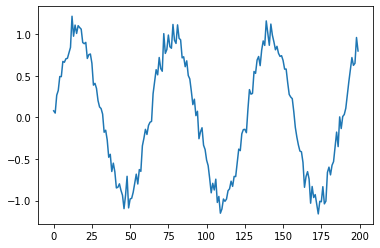

In [0]:
# make the original data
# the last part is a noise for data
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*.1

# plot it
plt.plot(series)
plt.show()

In [0]:
### Build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  # Final target is the last index of window in time series
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print('X.shape', X.shape, "Y.shape", Y.shape)

X.shape (190, 10) Y.shape (190,)


In [0]:
### try autoregressive linear model
i = Input(shape = (T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(loss = 'mse', optimizer = Adam(lr=0.1))

# train the rnn
# you don't want to split your data randomly (with something like train_test_split in sklearn)
# this wouldn't make sense because forecasting model has to predict future
# it can't train on points within that future
# Thus our model trains only on the first half of the dataset and
# validates on the second half.
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs = 80,
    validation_data = (X[-N//2:], Y[-N//2:])
)

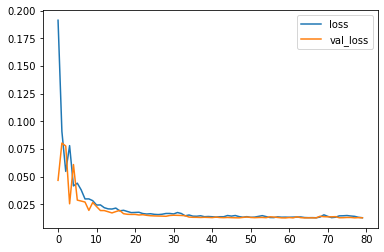

In [0]:
# Plot loss per iteration
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

In [0]:
# 'Wrong' forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1,-1))[0,0] # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

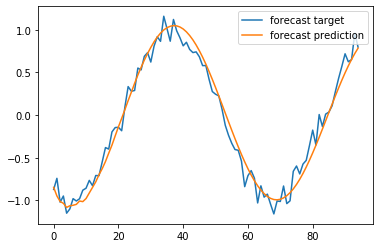

In [0]:
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()

In [0]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1) # shift every element to left
  # add the last prediction to last index so in next loop, we'll use our prediction as an input
  last_x[-1] = p

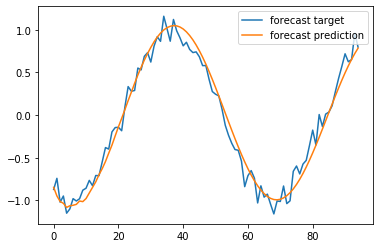

In [0]:
# these results are much more realistic for a real world scenerio
plt.plot(validation_target, label = 'forecast target')
plt.plot(validation_predictions, label = 'forecast prediction')
plt.legend()
plt.show()